# Heart Disease UCI – 2.5 Unsupervised Learning (Clustering)

## Introduction
This notebook explores latent structure in the Heart Disease UCI dataset using two complementary clustering methods:

- **K-Means** (partitioning, centroid-based, efficient)
- **Hierarchical Agglomerative (Ward linkage)** (reveals nested grouping structure)

The true disease label (`num`) is *never* used to fit models. After clustering we evaluate alignment with actual labels using Adjusted Rand Index (ARI) and Silhouette Score, plus a confusion matrix heatmap. This answers: *Do natural patient groupings reflect disease presence?*

**Deliverables**
- Elbow method plot (K vs Inertia) & heuristic K selection
- Final K-Means model + 2D scatter (raw first two features or PCA projection)
- Hierarchical dendrogram + consistent K cut
- Metrics: ARI & Silhouette (both methods)
- Confusion matrix heatmap (clusters vs true labels)
- Final interpretation summary

---

In [1]:
# 0. Imports & Configuration
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 110
print('Imports ready.')

Imports ready.


## 1. Load Dataset
We load `../data/selected_features.csv`. Feature matrix **X** is used for clustering; `num` is retained separately as **y** for external evaluation only.

In [2]:
# Load data
DATA_PATH = Path('../data/selected_features.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Missing data file: {DATA_PATH}')
df = pd.read_csv(DATA_PATH)
if 'num' not in df.columns: raise KeyError("Expected 'num' column not found.")
y = df['num']
X = df.drop(columns=['num'])
print('Shape:', X.shape)
print('First 5 rows:')
display(X.head())
print('Target distribution (proportion):')
display(y.value_counts(normalize=True).rename('proportion').to_frame().round(3))

Shape: (920, 17)
First 5 rows:


,cp_non-anginal,fbs_True,exang_True,chol,chol_per_age,ca,trestbps,slope_flat,sex_Male,heart_rate_reserve,oldpeak,thalch,thal_normal,slope_upsloping,cp_atypical angina,thal_reversable defect,age
0,False,True,False,233.0,3.698412,0,145.0,False,True,5.0,2.3,150.0,False,False,False,False,63
1,False,False,True,286.0,4.268656,3,160.0,True,True,-52.0,1.5,108.0,True,False,False,False,67
2,False,False,True,229.0,3.417910,2,120.0,True,True,9.0,2.6,129.0,False,False,False,True,67
3,True,False,False,250.0,6.756755,0,130.0,False,True,57.0,3.5,187.0,True,False,False,False,37
4,False,False,False,204.0,4.975609,0,130.0,False,False,42.0,1.4,172.0,True,True,True,False,41


Target distribution (proportion):


,proportion
num,
1,0.553
0,0.447


## 2. K-Means Clustering
We compute inertia for K = 1..10 (Elbow Method). A simple curvature heuristic proposes K. Then we fit K-Means and visualize clusters in 2D (PCA if >2 features).

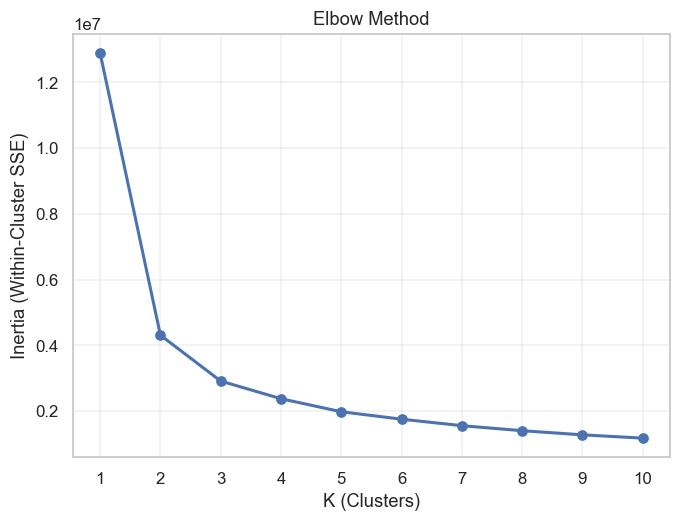

Chosen K (heuristic elbow): 9
Cluster counts:
0    126
1     78
2    175
3     99
4     21
5     92
6     94
7     95
8    140
Name: count, dtype: int64
Cluster counts:
0    126
1     78
2    175
3     99
4     21
5     92
6     94
7     95
8    140
Name: count, dtype: int64


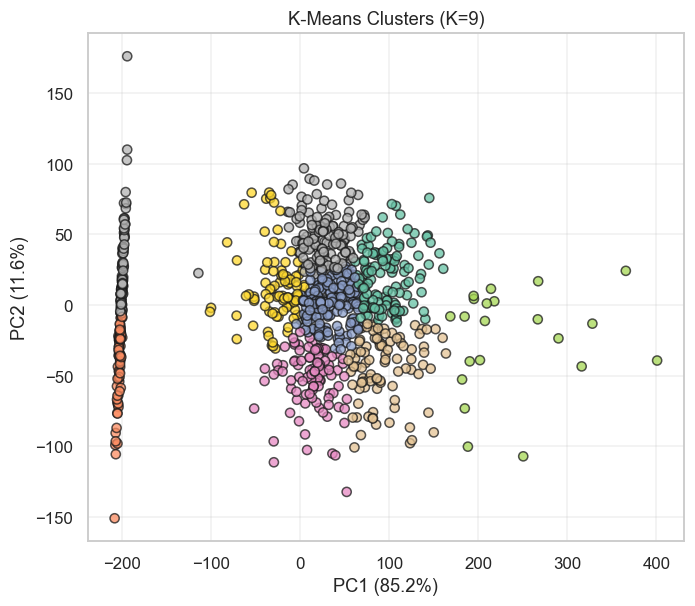

In [3]:
# Elbow analysis
K_RANGE = range(1, 11)
inertias = []
X_mat = X.values
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=15)
    km.fit(X_mat)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(list(K_RANGE), inertias, 'o-', lw=2)
plt.xlabel('K (Clusters)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.title('Elbow Method')
plt.xticks(list(K_RANGE))
plt.grid(alpha=0.3)
plt.show()

# Heuristic: choose K at largest relative drop then diminishing (second derivative)
if len(inertias) >= 3:
    second = np.diff(inertias, 2)
    elbow_k = second.argmin() + 2  # map index back
else:
    elbow_k = 2
elbow_k = max(2, elbow_k)
print(f'Chosen K (heuristic elbow): {elbow_k}')

# Final K-Means
kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=30)
cluster_kmeans = kmeans.fit_predict(X_mat)
print('Cluster counts:')
print(pd.Series(cluster_kmeans).value_counts().sort_index())

# 2D visualization
if X.shape[1] > 2:
    pca2 = PCA(n_components=2, random_state=42)
    X_vis = pca2.fit_transform(X_mat)
    xlab = f'PC1 ({pca2.explained_variance_ratio_[0]:.1%})'
    ylab = f'PC2 ({pca2.explained_variance_ratio_[1]:.1%})'
else:
    X_vis = X_mat[:, :2]
    xlab, ylab = X.columns[:2]
plt.figure(figsize=(7,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=cluster_kmeans, cmap='Set2', edgecolor='k', alpha=0.75)
plt.title(f'K-Means Clusters (K={elbow_k})')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid(alpha=0.3)
plt.show()

## 3. Hierarchical Clustering
We apply Ward linkage (variance-minimizing) and truncate the dendrogram for readability, then cut at the same K to obtain cluster labels.

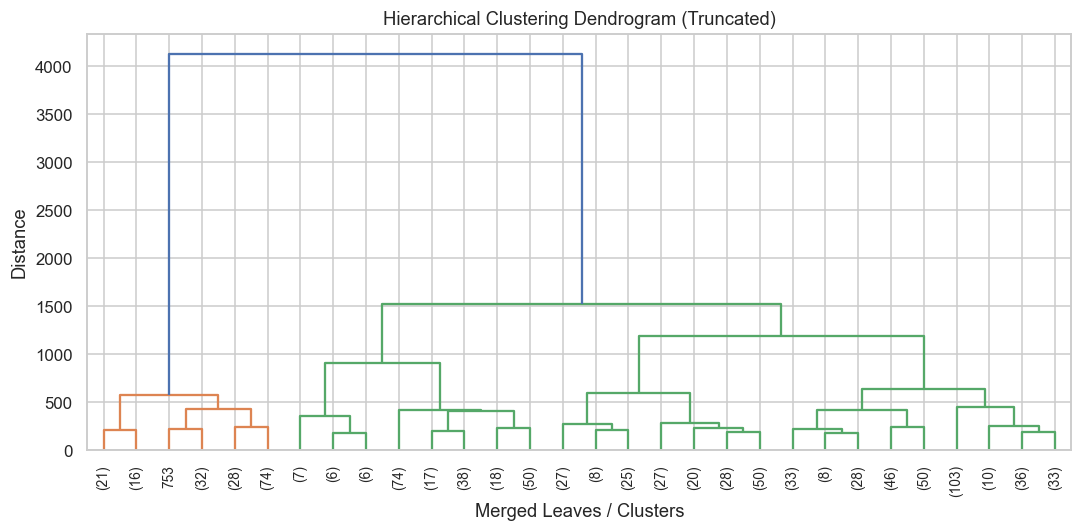

Hierarchical cluster counts:
0     37
1    135
2     19
3    197
4     60
5    125
6    165
7    103
8     79
Name: count, dtype: int64


In [4]:
# Hierarchical clustering (Ward)
linked = linkage(X_mat, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=9)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Merged Leaves / Clusters')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

cluster_hier = fcluster(linked, t=elbow_k, criterion='maxclust') - 1  # zero-base labels
print('Hierarchical cluster counts:')
print(pd.Series(cluster_hier).value_counts().sort_index())

## 4. Cluster Evaluation & Comparison with True Labels
We now assess how well unsupervised clusters mirror the actual heart disease label using ARI (external agreement) and Silhouette (internal cohesion/separation). We also inspect confusion matrices.

Cluster Evaluation Metrics:


,Adjusted Rand Index,Silhouette Score
Method,,
K-Means,0.0400,0.2780
Hierarchical,0.0466,0.2285


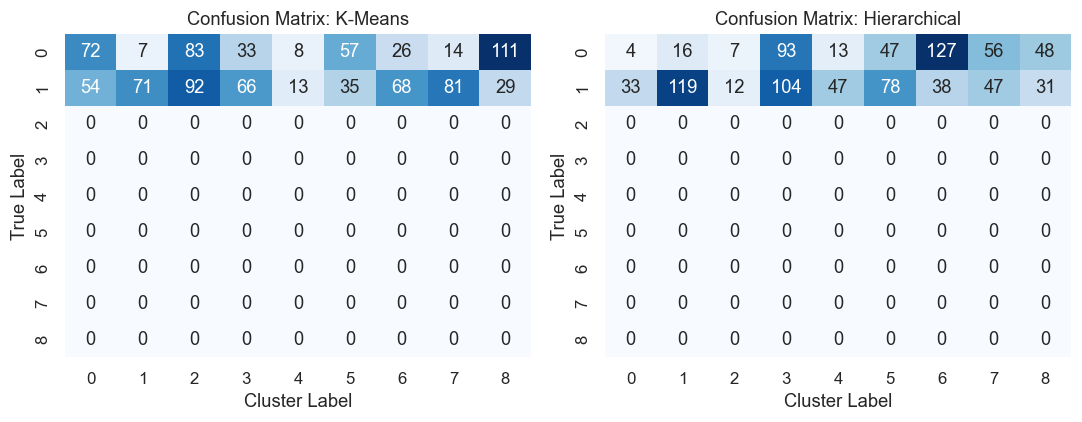

Cross-tabulations (counts):
K-Means vs True:
num      0   1
row_0         
0       72  54
1        7  71
2       83  92
3       33  66
4        8  13
5       57  35
6       26  68
7       14  81
8      111  29
Hierarchical vs True:
num      0    1
row_0          
0        4   33
1       16  119
2        7   12
3       93  104
4       13   47
5       47   78
6      127   38
7       56   47
8       48   31
num      0    1
row_0          
0        4   33
1       16  119
2        7   12
3       93  104
4       13   47
5       47   78
6      127   38
7       56   47
8       48   31


In [6]:
# Metrics & confusion matrices
ari_km = adjusted_rand_score(y, cluster_kmeans)
sil_km = silhouette_score(X_mat, cluster_kmeans)
ari_h = adjusted_rand_score(y, cluster_hier)
sil_h = silhouette_score(X_mat, cluster_hier)
metrics = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical'],
    'Adjusted Rand Index': [ari_km, ari_h],
    'Silhouette Score': [sil_km, sil_h]
}).set_index('Method')
print('Cluster Evaluation Metrics:')
display(metrics.round(4))

cm_k = confusion_matrix(y, cluster_kmeans)
cm_h = confusion_matrix(y, cluster_hier)
fig, axes = plt.subplots(1,2, figsize=(10,4))
for ax, cm, title in zip(axes, [cm_k, cm_h], ['K-Means', 'Hierarchical']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {title}')
    ax.set_xlabel('Cluster Label')
    ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

print('Cross-tabulations (counts):')
print('K-Means vs True:')
print(pd.crosstab(cluster_kmeans, y))
print('Hierarchical vs True:')
print(pd.crosstab(cluster_hier, y))